In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
import numpy as np
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("financials.csv")

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          505 non-null    object 
 1   Name            505 non-null    object 
 2   Sector          505 non-null    object 
 3   Price           505 non-null    float64
 4   Price/Earnings  503 non-null    float64
 5   Dividend Yield  505 non-null    float64
 6   Earnings/Share  505 non-null    float64
 7   52 Week Low     505 non-null    float64
 8   52 Week High    505 non-null    float64
 9   Market Cap      505 non-null    float64
 10  EBITDA          505 non-null    float64
 11  Price/Sales     505 non-null    float64
 12  Price/Book      497 non-null    float64
 13  SEC Filings     505 non-null    object 
dtypes: float64(10), object(4)
memory usage: 55.4+ KB
None


In [5]:
print(f"Duplicate rows: {df.duplicated().sum()}")
print("Missing values:")
print(df.isna().sum())

Duplicate rows: 0
Missing values:
Symbol            0
Name              0
Sector            0
Price             0
Price/Earnings    2
Dividend Yield    0
Earnings/Share    0
52 Week Low       0
52 Week High      0
Market Cap        0
EBITDA            0
Price/Sales       0
Price/Book        8
SEC Filings       0
dtype: int64


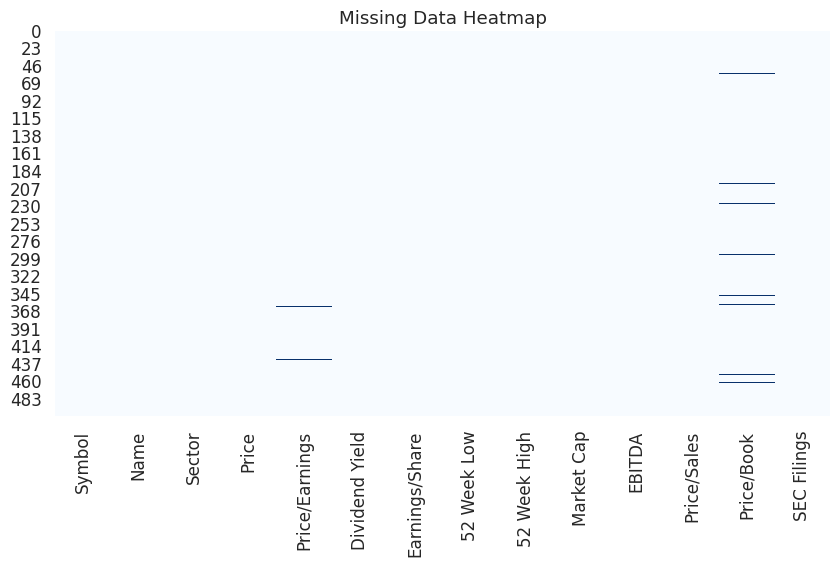

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="Blues")
plt.title("Missing Data Heatmap")
plt.show()

In [13]:
df.isnull().sum().sort_values(ascending=False)
df.isnull().mean().round(3)*100

,0
Symbol,0.0
Name,0.0
Sector,0.0
Price,0.0
Price/Earnings,0.4
Dividend Yield,0.0
Earnings/Share,0.0
52 Week Low,0.0
52 Week High,0.0
Market Cap,0.0


In [14]:
#there are 0.4% of missing values in Price/Earnings and 1.6% of missing values in Price/Book, we just remove them without deeper analysis
df = df.dropna(subset=['Price/Earnings', 'Price/Book'])

In [15]:
print(df.describe(include='all'))

       Symbol    Name                  Sector        Price  Price/Earnings  \
count     495     495                     495   495.000000      495.000000   
unique    495     495                      11          NaN             NaN   
top       ZTS  Zoetis  Consumer Discretionary          NaN             NaN   
freq        1       1                      82          NaN             NaN   
mean      NaN     NaN                     NaN   104.106505       24.654303   
std       NaN     NaN                     NaN   135.372594       40.767081   
min       NaN     NaN                     NaN     2.820000     -251.530000   
25%       NaN     NaN                     NaN    46.355000       15.350000   
50%       NaN     NaN                     NaN    73.920000       19.450000   
75%       NaN     NaN                     NaN   116.735000       25.770000   
max       NaN     NaN                     NaN  1806.060000      520.150000   

        Dividend Yield  Earnings/Share  52 Week Low  52 Week Hi

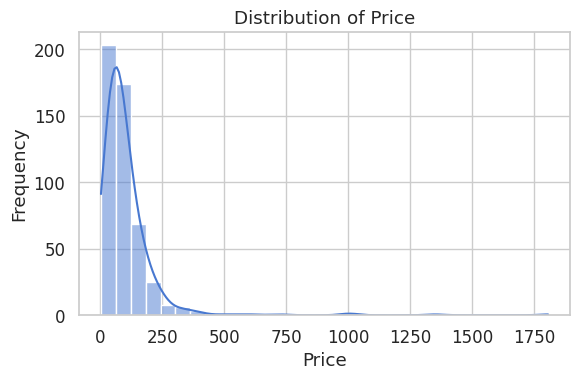

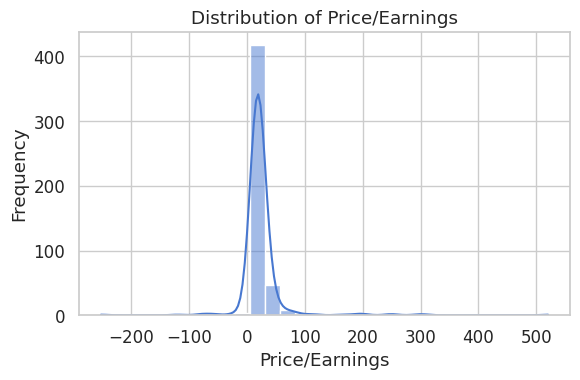

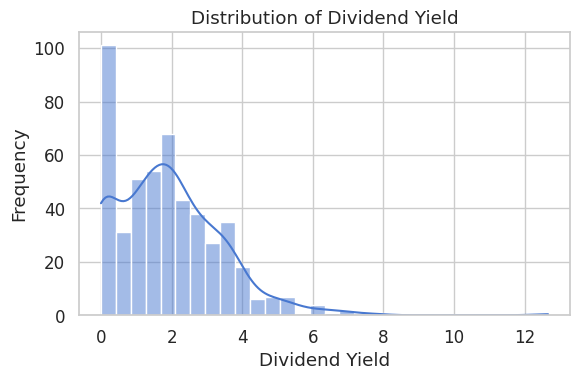

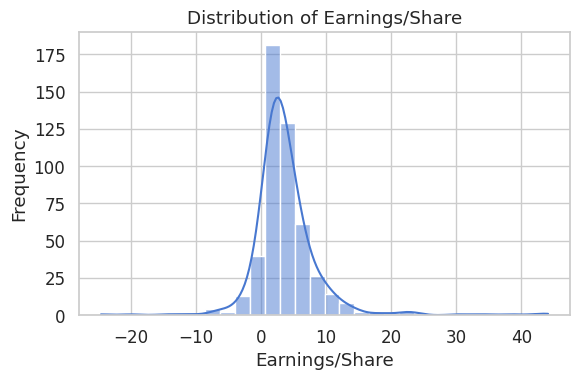

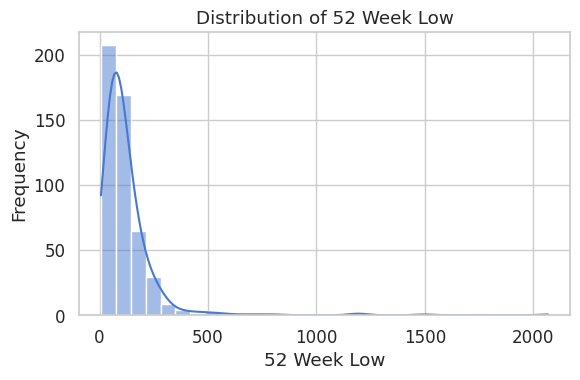

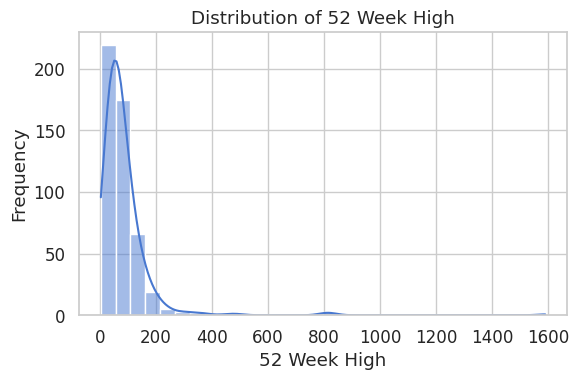

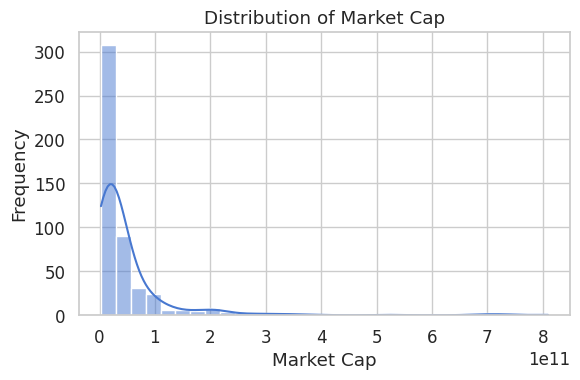

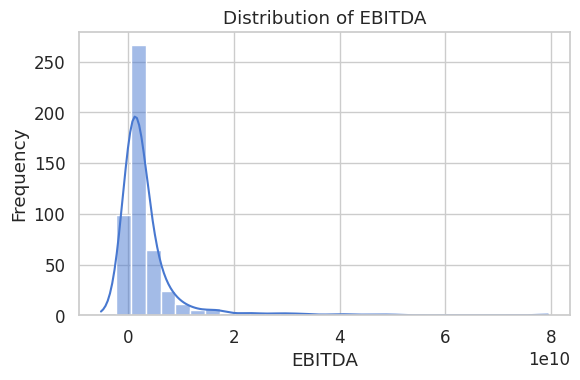

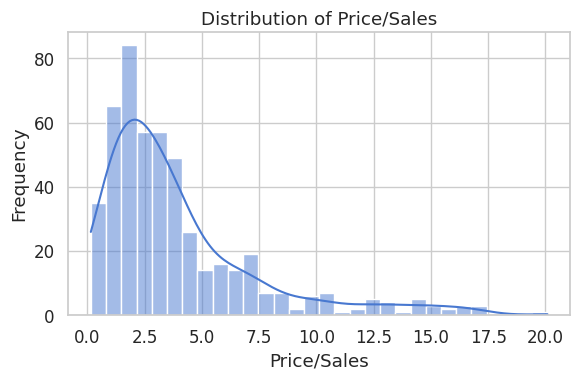

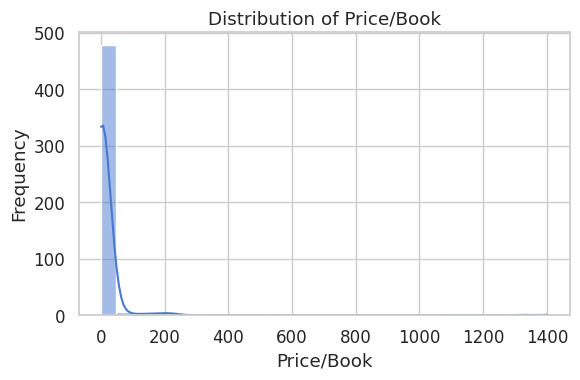

In [16]:
num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

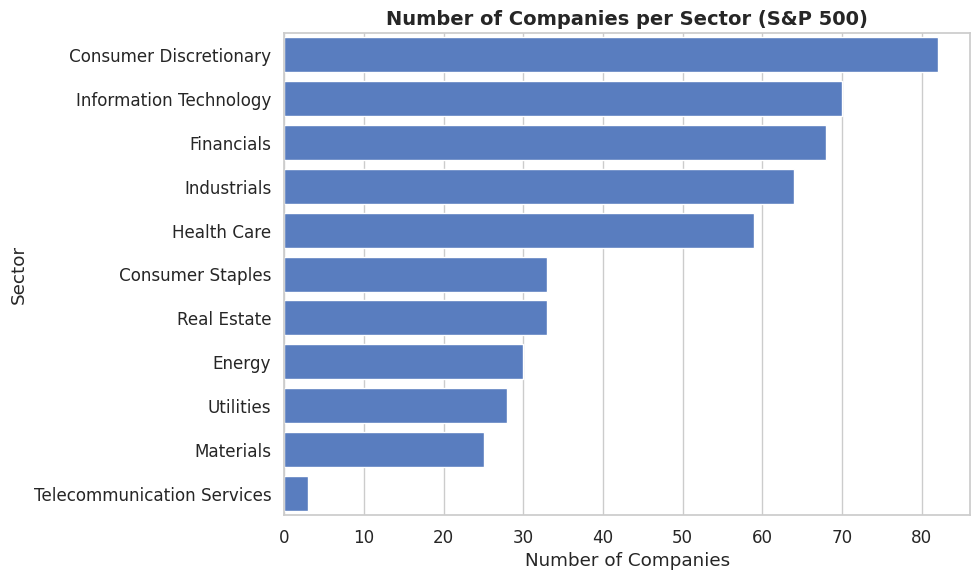

In [20]:
sector_counts = df['Sector'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.values, y=sector_counts.index)
plt.title("Number of Companies per Sector (S&P 500)", fontsize=14, weight='bold')
plt.xlabel("Number of Companies")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

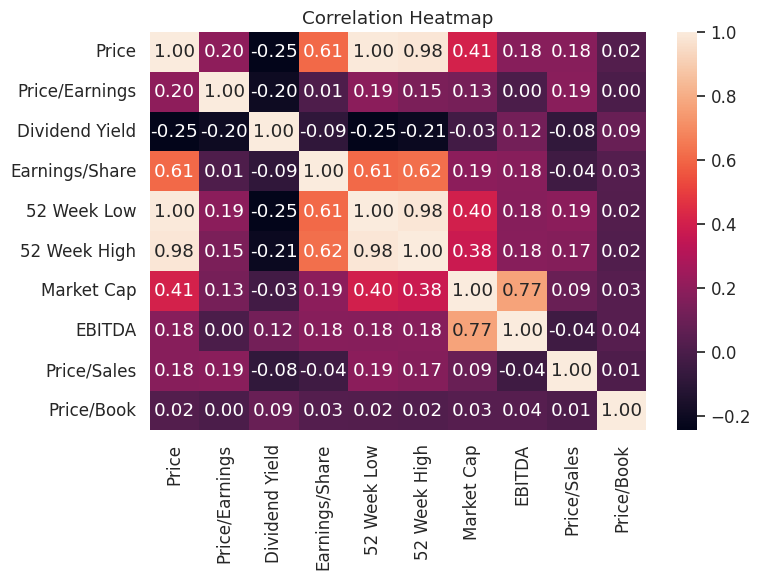

In [17]:
if len(num_cols) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

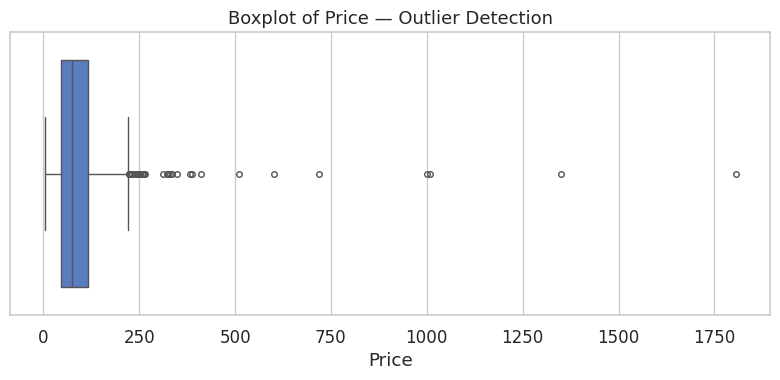

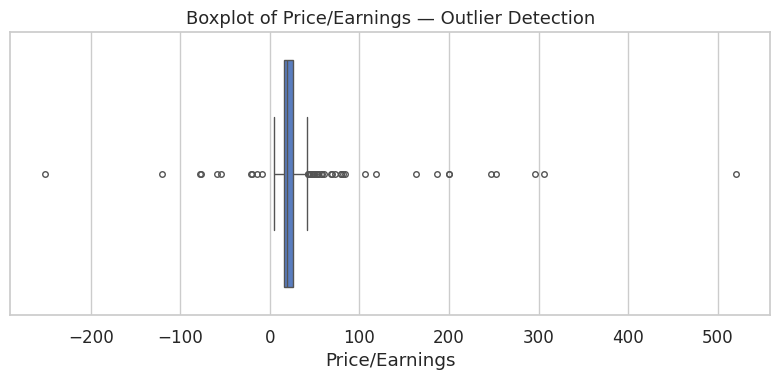

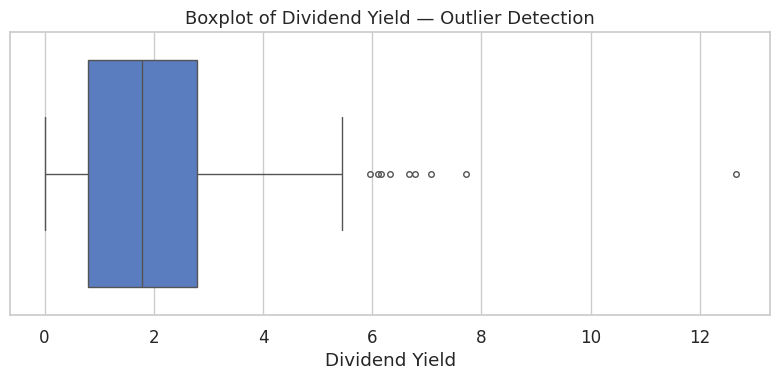

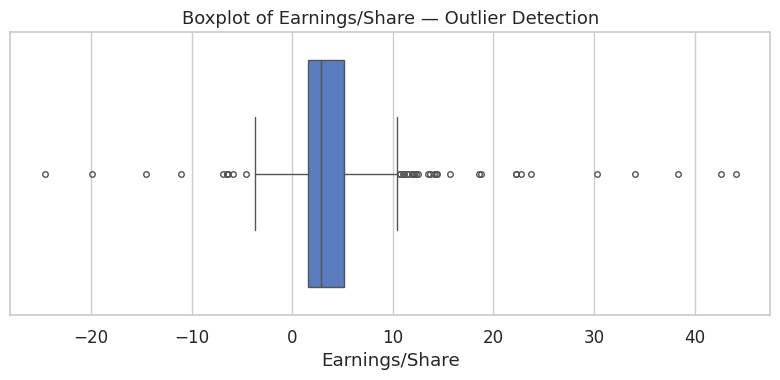

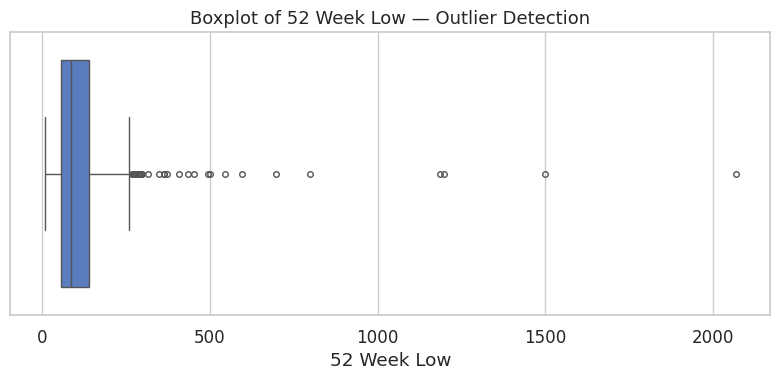

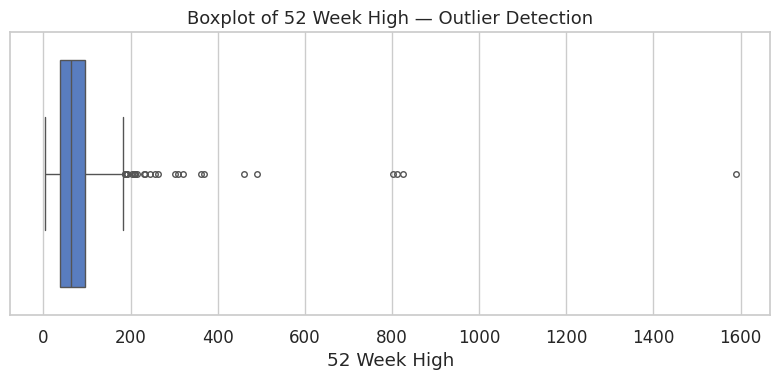

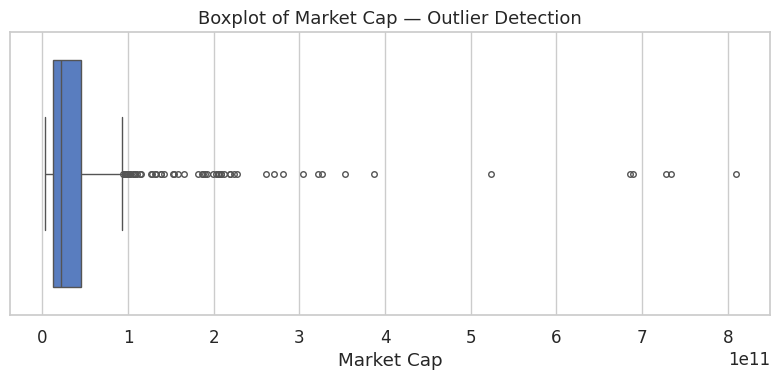

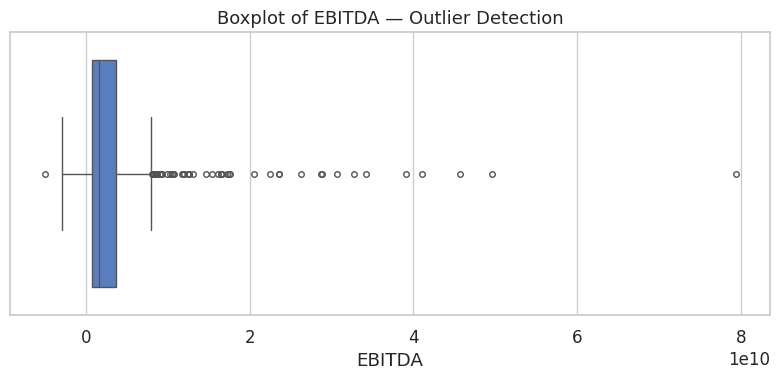

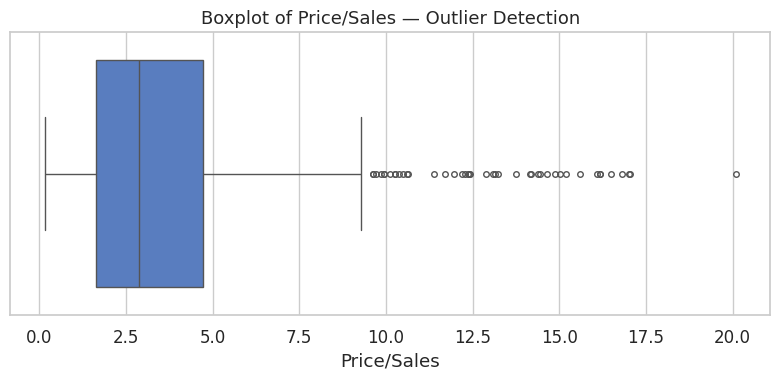

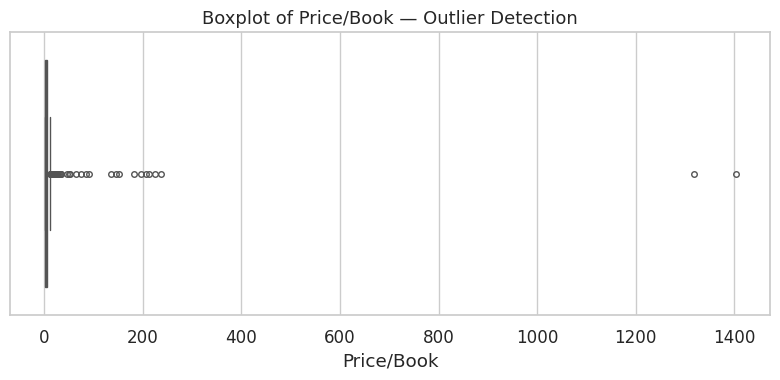

In [18]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], fliersize=4)
    plt.title(f'Boxplot of {col} — Outlier Detection', fontsize=13)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

1. Most financial variables, such as Price, Market Cap, Earnings/Share, and P/E Ratio, show right-skewed distributions, with a few extremely large values pulling the mean above the median. This reflects the presence of a few large dominating firms.
2. The most common sector is Consumer Discretionary (82 companies), followed by Information Technology and Financials. The sector distribution highlights the current structure of the U.S. equity market, where consumer and tech-driven businesses represent a substantial share of total capitalization.
3. We observe strong interdependence among price-related variables: Market Cap, Price, and EBITDA. Valuation ratios such as P/E and Dividend Yield behave more independently. It means that larger companies tend to have higher earnings and market values, but valuation multiples vary independently of company size or raw price. A negative correlation between Dividend Yield and Price means that higher-priced growth stocks often pay smaller dividends, and lower-growth firms tend to have higher yields.
4. High-end outliers in Price, Market Cap, and P/E are not data errors; it's large-scale or high-growth companies. Negative outliers in Earnings/Share, P/E, and EBITDA represent firms operating at a loss.

# Question
Do companies in the Information Technology sector have higher average Price/Earnings ratios than companies in other sectors?

# Null hypothesis $H_0$:
The mean P/E ratio of Information Technology companies = the mean P/E ratio of non-technology companies.

#Alternative hypothesis $H_1$:
The mean P/E ratio of Information Technology companies > the mean P/E ratio of other sectors.

In [22]:
tech = df[df['Sector'] == 'Information Technology']['Price/Earnings']
non_tech = df[df['Sector'] != 'Information Technology']['Price/Earnings']
t_stat, p_val = stats.ttest_ind(tech, non_tech, equal_var=False, alternative='greater')
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.5f}")

T-statistic: 1.758
P-value: 0.04142


$p=0.04142<0.05$. Hence, we reject the null hypothesis. Information Technology companies have higher mean P/E ratios than firms in other sectors. It supports the view that investors assign higher valuations to tech firms due to their stronger growth expectations.

In [61]:
X = df[["Earnings/Share", "Market Cap"]]
y = df["Price"]

In [62]:
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

In [63]:
reg_models = {
    "LinearRegression": Pipeline([
        ("scale", num_pipe),
        ("lin", LinearRegression())
    ]),
    "RidgeCV": Pipeline([
        ("scale", num_pipe),
        ("ridge", RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5))
    ]),
    "LassoCV": Pipeline([
        ("scale", num_pipe),
        ("lasso", LassoCV(alphas=[0.001, 0.01, 0.1, 1], cv=5, max_iter=5000, random_state=42))
    ])
}

In [64]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
reg_results = []
for name, pipe in reg_models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2", n_jobs=-1)
    reg_results.append({
        "Model": name,
        "Mean R2": np.mean(scores),
        "Std R2": np.std(scores),
        "Fold R2": np.round(scores, 3)
    })

In [65]:
reg_df = pd.DataFrame(reg_results).sort_values("Mean R2", ascending=False).reset_index(drop=True)
print(reg_df.to_string(index=False))

           Model  Mean R2   Std R2                             Fold R2
         RidgeCV 0.359890 0.130889  [0.28, 0.381, 0.289, 0.606, 0.244]
         LassoCV 0.332952 0.171699 [0.252, 0.424, 0.227, 0.622, 0.139]
LinearRegression 0.332859 0.171551 [0.252, 0.424, 0.227, 0.622, 0.139]
